# Deep Deterministic Policy Gradient

In [1]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

from dotenv import load_dotenv



load_dotenv()
print(os.getenv('DEVICE'))


None


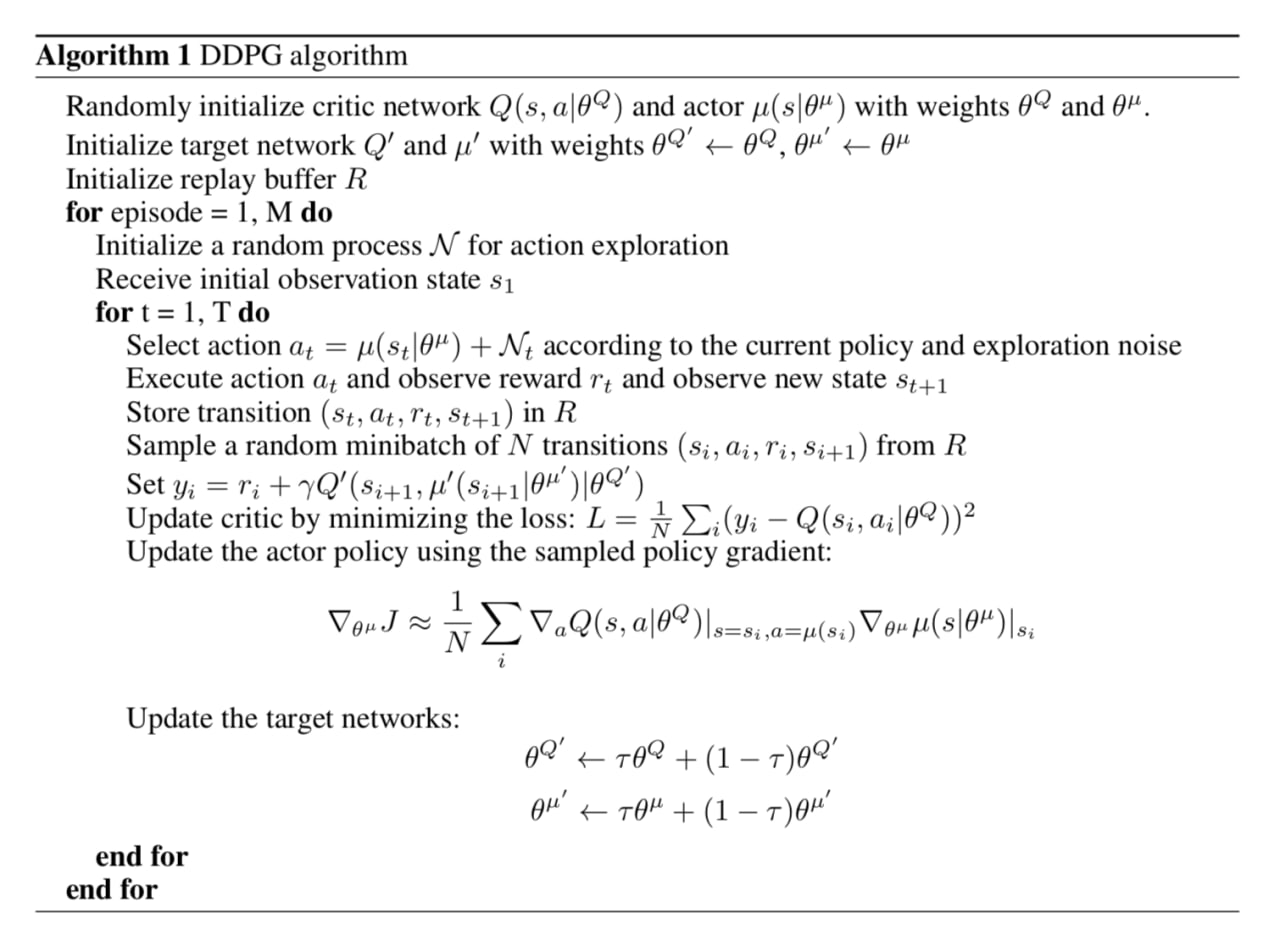

In [2]:

# Ornstein–Uhlenbeck noise for exploration
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [3]:

class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        # takes #batchsize random idexes from 0 until maxmem
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

In [4]:

# Q function approximator
# says how good it was to take action A in state S
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='./models'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg.pth')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        # self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        # self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)

        self.q = nn.Linear(self.fc2_dims, 1)

        # compute the fan-ins for weight initialisation (see DDPG paper)
        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1. / np.sqrt(self.action_value.weight.data.size()[0])
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        self.device = "cuda" if T.cuda.is_available() else "cpu"
#         self.device = T.device(os.environ.get('DEVICE'))

        self.to(self.device)

    # TODO: shorten this
    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        # state_value = F.relu(state_value)
        # action_value = F.relu(self.action_value(action))
        action_value = self.action_value(action)
        # TODO: understand why adding and not concatonate?
        # introduce the action values in the second hidden layer (see DDPG paper)
        state_action_value = F.relu(T.add(state_value, action_value))
        # state_action_value = T.add(state_value, action_value)
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')

        if not os.path.exists('./models'):
            os.makedirs('./models')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name + '_best.pth')
        T.save(self.state_dict(), checkpoint_file)



In [5]:

# policy approximator
# decides what action to use in current state
# OUTPUTS AN ACTION
class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='./models'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name + '_ddpg.pth')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        # self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        # self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        # compute the fan-ins for weight initialisation (see DDPG paper)
        f2 = 1. / np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f1 = 1. / np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
#         self.device = T.device(os.environ.get('DEVICE'))

        self.to(self.device)

    # TODO: shorten this
    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        # we use tanh since lunar lander has action space [-1,1]
        # for other environments with different action spaces just multiply the output
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')

        if not os.path.exists('./models'):
            os.makedirs('./models')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name + '_best.pth')
        T.save(self.state_dict(), checkpoint_file)



In [15]:

class Agent():
    def __init__(self, alpha, beta, input_dims, tau, env_id, n_actions, gamma=0.99,
                 max_size=1000000, fc1_dims=400, fc2_dims=300,
                 batch_size=64):
        self.algo = "DDPG"
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)

        self.noise = OUActionNoise(mu=np.zeros(n_actions))

        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                  n_actions=n_actions, name=env_id + '_actor')
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                    n_actions=n_actions, name=env_id + '_critic')

        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                         n_actions=n_actions, name=env_id + '_target_actor')

        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                           n_actions=n_actions, name=env_id + '_target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        # add noise
        mu_prime = mu + T.tensor(self.noise(),
                                 dtype=T.float).to(self.actor.device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return None, None

        states, actions, rewards, states_, done = \
            self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        # set Q value of terminal states to 0 (since there will be no future reward)
        critic_value_[done] = 0.0
        # make a list of all critic values (previously it was list of lists)
        critic_value_ = critic_value_.view(-1)

        # y =  r + Q'( s(i+1), U'(s(i+1))
        # --> target = reward + The Q-value (given by target critic) of the action (given by target actor)
        # of the new state
        target = rewards + self.gamma * critic_value_
        # add batch dimension
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        # actor loss : mean of the gradient of the Q value of the action the actor would take
        # minus because gradient ASCENT
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        # soft update the target networks in direction of current networks
        self.update_network_parameters()

        return actor_loss.detach().numpy(), critic_loss.detach().numpy()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau * critic_state_dict[name].clone() + \
                                      (1 - tau) * target_critic_state_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau * actor_state_dict[name].clone() + \
                                     (1 - tau) * target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        # for batchnorm:
        # self.target_critic.load_state_dict(critic_state_dict, strict=False)
        # self.target_actor.load_state_dict(actor_state_dict, strict=False)


In [16]:


def simple_plot(scores, mean_scores, epoch):
    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    # plt.ylim(ymin=0)
    plt.text(len(scores) - 1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores) - 1, mean_scores[-1], str(mean_scores[-1]))
    if epoch % 10 == 0:
        plt.show()


def plot_learning_curve(x, scores, figure_file, algo, env_id):

    if not os.path.exists('./plots'):
        os.makedirs('./plots')

    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i - 100):(i + 1)])
    plt.plot(x, running_avg)
    plt.title(f'{algo} {env_id} avg 100 scores')
    plt.savefig(figure_file)
    plt.close()


In [17]:

# Hyperparams
n_games = 10
load_checkpoint = False
iterations = 1

env_id = 'LunarLanderContinuous-v2'

env = gym.make(env_id)

all_rewards = []
all_actor_losses = []
all_critic_losses = []
all_trajectory_lengths = []


def train(iteration):
    filename = agent.algo + "_" + env_id + "_" + str(n_games) + "games" + "_" + str(iteration) + '.png'
    figure_file = 'plots/' + filename

    best_score = env.reward_range[0]
    score_history = []

    if load_checkpoint:
        agent.load_models()
        if os.environ.get('RENDER') == "t":
            env.render(mode='human')

    steps = 0
    for i in range(n_games):
        observation, _ = env.reset()
        done = False
        score = 0

        count = 0
        a_losses = []
        c_losses = []

        # for every episode:
        while not done:
            if os.environ.get('RENDER') == "t":
                env.render()

            action = agent.choose_action(observation)
            observation_, reward, done, _,  info = env.step(action[0])
            count += 1
            steps += 1
            agent.remember(observation, action, reward, observation_, done)
            if not load_checkpoint:
                actor_loss, critic_loss = agent.learn()
                if actor_loss is not None:
                    a_losses.append(actor_loss)
                    c_losses.append(critic_loss)
            score += reward
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        all_rewards.append(score)
        all_trajectory_lengths.append(count)
        all_actor_losses.append(np.mean(a_losses))
        all_critic_losses.append(np.mean(c_losses))

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print(env_id, "|", 'episode', i, "|", 'score %.1f' % score, "|",
              '100 games avg %.1f' % avg_score, "|",
              'steps %d' % steps, "|"
              )

    if not load_checkpoint:
        x = [i + 1 for i in range(n_games)]
        plot_learning_curve(x, score_history, figure_file, agent.algo, env_id)


for iteration in range(iterations):
    agent = Agent(alpha=0.0001, beta=0.001,
                    input_dims=env.observation_space.shape, tau=0.001, env_id=env_id,
                    batch_size=64, fc1_dims=400, fc2_dims=300,
                    n_actions=env.action_space.shape[0])
    train(iteration + 1)


/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/DDPG/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rafik/Documents/InnoUni/s24/rl-project/Lunar-Landing/DDPG/venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
LunarLanderContinuous-v2 | episode 0 | score -94.1 | 100 games avg -94.1 | steps 55 |
LunarLanderContinuous-v2 | episode 1 | score -291.4 | 100 games avg -192.8 | steps 150 |
LunarLanderContinuous-v2 | episode 2 | score -433.5 | 100 games avg -273.0 | steps 230 |
LunarLanderContinuous-v2 | episode 3 | score -487.7 | 100 games avg -326.7 | steps 286 |
LunarLanderContinuous-v2 | episode 4 | score -551.2 | 100 games avg -371.6 | steps 347 |
LunarLanderContinuous-v2 | episode 5 | score -612.1 | 100 games avg -411.7 | steps 412 |
LunarLanderContinuous-v2 | episode 6 | score -1392.6 | 100 games avg -551.8 | steps 538 |
LunarLanderContinuous-v2 | episode 7 | score -108.7 | 100 games avg -496.4 | steps 626 |
LunarLanderContinuous-v2 | episode 8 | score -116.1 | 100 games avg -454.2 | steps 680 |
LunarLanderContinuous-v2 | episode 9 | score -286.1 | 100 games avg -437.4 | steps 759 |


In [19]:
import pandas as pd

all_results = {
    "rewards": all_rewards,
    "actor_losses": all_actor_losses,
    "critic_losses": all_critic_losses,
    "trajectory_lengths": all_trajectory_lengths
}

df = pd.DataFrame(all_results)
df.to_csv('results.csv')

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


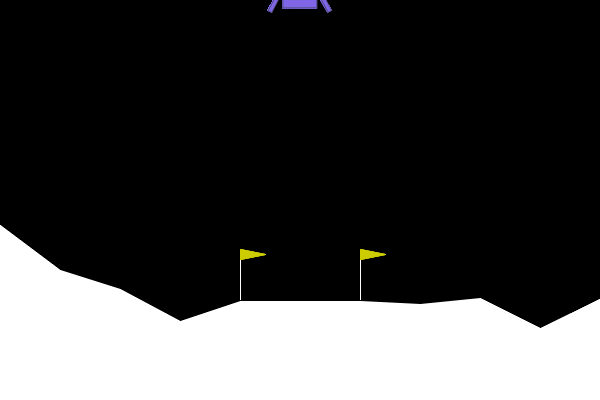

In [20]:
from IPython.display import Image as IImage
from PIL import Image


def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)
    
    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with T.no_grad():
            action = agent.choose_action(obs)
            
        obs, _, terminated, truncated, _ = env.step(action[0])
        render_res  = env.render()
        imgs.append(render_res)
        
        if terminated or truncated:
            break

    return imgs

agent = Agent(alpha=0.0001, beta=0.001,
                    input_dims=env.observation_space.shape, tau=0.001, env_id=env_id,
                    batch_size=64, fc1_dims=400, fc2_dims=300,
                    n_actions=env.action_space.shape[0])

env = gym.make(env_id, render_mode="rgb_array")
agent.load_models()
imgs = rendered_rollout(agent.actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")